# Model Call version 1

In [ ]:
from langchain_core.tools import tool
from amadeus import Client, ResponseError
import os
from dotenv import load_dotenv
from tenacity import retry, stop_after_attempt, wait_exponential

# Load variables from the .env file
load_dotenv()


@tool
def flight(dep: str, arr: str, date: str) -> str:
    """Find Three letter code for Departure and arrival / find date of trip"""
    
    amadeus = Client(
        client_id=os.getenv("AMADEUS_CLIENT_ID"),
        client_secret=os.getenv("AMADEUS_CLIENT_SECRET"),
    )

    response = amadeus.shopping.flight_offers_search.get(
        originLocationCode=dep,
        destinationLocationCode=arr,
        departureDate=date,
        adults=1,
    )
    flights = response.data


    return flights[:3]

@tool
def hotels(city: str) -> str:
    "Find three letter location code for hotel information for trip destination"
    
    amadeus = Client(
        client_id=os.getenv("AMADEUS_CLIENT_ID"),
        client_secret=os.getenv("AMADEUS_CLIENT_SECRET"),
    )

    response = amadeus.reference_data.locations.hotels.by_city.get(
        cityCode=city,
        ratings=[5],
        radius=30)

    hotels = response.data

    return hotels[:3]

In [2]:
from langchain_openai import ChatOpenAI
from langchain_core.prompts import PromptTemplate
from langgraph.graph import END, START, StateGraph, MessagesState
from langchain.prompts import SystemMessagePromptTemplate, PromptTemplate
from langchain.agents import AgentExecutor, create_tool_calling_agent
from langchain.chains.llm import LLMChain
from langchain import hub



# Initialize the language model
llm = ChatOpenAI(model="gpt-3.5-turbo-0125")


# Define the preprocessing function
def preprocessing_function(state):
    input_text = state['input']
    llm = ChatOpenAI(model="gpt-3.5-turbo-0125")

    template_simp = """
    You are a rephraser.
    Look at past chat results to identify the accurate quesitons and
    replace all location names to 3 letter iata codes in the input below and output the replaced text.
    
    input : {input}
    """
    prompt = PromptTemplate(
        template = template_simp,
        input_variables=['input']
    )

    # Define a preprocessing chain (e.g., another LLM or function)
    preprocessing_chain = LLMChain(llm=llm, prompt = prompt, output_key = 'preprocessed_input')

    result = preprocessing_chain.run(input_text)

    return {'preprocessed_input': result}

# Define the agent execution function
def agent_execution_function(state):
    preprocessed_input = state['preprocessed_input']
    llm = ChatOpenAI(model="gpt-3.5-turbo-0125")
    # Here, you would integrate your agent executor logic
    # For demonstration, we'll just return the preprocessed input
    # agent_output = f"Agent received: {preprocessed_input}"

    # Define a prompt template
    prompt = hub.pull("hwchase17/openai-tools-agent")

        # Define the new system message
    new_system_message = SystemMessagePromptTemplate(
        prompt=PromptTemplate.from_template("You are a travel agency. explain the information kindly to customers")
    )

    # Replace the first message with the new system message
    prompt.messages[0] = new_system_message

    # Define tools
    tools = [flight, hotels]  # Replace with your actual tool instances

    # Create the agent
    agent = create_tool_calling_agent(llm, tools, prompt)

    # Create the agent executor
    agent_executor = AgentExecutor(agent=agent, tools=tools, verbose=True)

    agent_output = agent_executor.invoke({'input':preprocessed_input})

    return {'agent_output': agent_output}

# Define the state structure
class AgentState(dict):
    input: str
    preprocessed_input: str
    agent_output: str

# Initialize the graph
graph = StateGraph(AgentState)

# Add nodes to the graph
graph.add_node("preprocessing", preprocessing_function)
graph.add_node("agent_execution", agent_execution_function)

# Define the edges
graph.set_entry_point("preprocessing")
graph.add_edge("preprocessing", "agent_execution")
# graph.add_edge("agent_execution", END)


# from langgraph.store.memory import InMemoryStore
from langgraph.checkpoint.memory import MemorySaver
# in_memory_store = InMemoryStore()
checkpointer = MemorySaver()

app = graph.compile(checkpointer=checkpointer)
# app = graph.compile(checkpointer=checkpointer, store=in_memory_store)

# # Compile the graph into a runnable application
# app = graph.compile()

In [3]:
config = {"configurable": {"thread_id": "1"}}
initial_state = {'input': 'I want to book a flight from paris to london on 2024-12-15'}
final_state = app.invoke(initial_state, config, stream_mode="values")

C:\Users\JaeHoBahng\AppData\Local\Temp\ipykernel_12996\1356581903.py:33: LangChainDeprecationWarning: The class `LLMChain` was deprecated in LangChain 0.1.17 and will be removed in 1.0. Use :meth:`~RunnableSequence, e.g., `prompt | llm`` instead.
  preprocessing_chain = LLMChain(llm=llm, prompt = prompt, output_key = 'preprocessed_input')
C:\Users\JaeHoBahng\AppData\Local\Temp\ipykernel_12996\1356581903.py:35: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use :meth:`~invoke` instead.
  result = preprocessing_chain.run(input_text)
c:\Users\JaeHoBahng\anaconda3\envs\llm\Lib\site-packages\langsmith\client.py:241: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(




> Entering new AgentExecutor chain...

Invoking: `flight` with `{'dep': 'CDG', 'arr': 'LHR', 'date': '2024-12-15'}`


[{'type': 'flight-offer', 'id': '1', 'source': 'GDS', 'instantTicketingRequired': False, 'nonHomogeneous': False, 'oneWay': False, 'isUpsellOffer': False, 'lastTicketingDate': '2024-12-15', 'lastTicketingDateTime': '2024-12-15', 'numberOfBookableSeats': 9, 'itineraries': [{'duration': 'PT19H55M', 'segments': [{'departure': {'iataCode': 'CDG', 'terminal': '2D', 'at': '2024-12-15T20:35:00'}, 'arrival': {'iataCode': 'ATH', 'at': '2024-12-16T00:40:00'}, 'carrierCode': 'A3', 'number': '615', 'aircraft': {'code': '32Q'}, 'operating': {'carrierCode': 'A3'}, 'duration': 'PT3H5M', 'id': '200', 'numberOfStops': 0, 'blacklistedInEU': False}, {'departure': {'iataCode': 'ATH', 'at': '2024-12-16T13:25:00'}, 'arrival': {'iataCode': 'LHR', 'terminal': '2', 'at': '2024-12-16T15:30:00'}, 'carrierCode': 'A3', 'number': '602', 'aircraft': {'code': '32Q'}, 'operating': {'carrierCode': 'A3

In [4]:
# config = {"configurable": {"thread_id": "2"}}
final_state = app.invoke({'input': 'What about for 2025-01-01'}, config, stream_mode="values")

c:\Users\JaeHoBahng\anaconda3\envs\llm\Lib\site-packages\langsmith\client.py:241: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(




> Entering new AgentExecutor chain...

Invoking: `flight` with `{'dep': 'JFK', 'arr': 'LAX', 'date': '2025-01-01'}`
responded: Sure, I will find the flight and hotel information for January 1, 2025. Let me gather the information for you.

[{'type': 'flight-offer', 'id': '1', 'source': 'GDS', 'instantTicketingRequired': False, 'nonHomogeneous': False, 'oneWay': False, 'isUpsellOffer': False, 'lastTicketingDate': '2024-11-28', 'lastTicketingDateTime': '2024-11-28', 'numberOfBookableSeats': 3, 'itineraries': [{'duration': 'PT14H10M', 'segments': [{'departure': {'iataCode': 'JFK', 'at': '2025-01-01T06:59:00'}, 'arrival': {'iataCode': 'LAS', 'terminal': '3', 'at': '2025-01-01T09:28:00'}, 'carrierCode': 'F9', 'number': '3237', 'aircraft': {'code': '32Q'}, 'operating': {'carrierCode': 'F9'}, 'duration': 'PT5H29M', 'id': '28', 'numberOfStops': 0, 'blacklistedInEU': False}, {'departure': {'iataCode': 'LAS', 'terminal': '3', 'at': '2025-01-01T17:00:00'}, 'arrival': {'iataCode': 'ONT', 'at': '2

# Model calling with more control

In [86]:
from langchain_core.tools import tool
from amadeus import Client, ResponseError
import os
from dotenv import load_dotenv
from tenacity import retry, stop_after_attempt, wait_exponential

# Load variables from the .env file
load_dotenv()


@tool
def flight(departure: str, arrival: str, date: str, people: int = 1, nonstop: str = 'false'):
    """
    You are finding details on flight requests. The definitions of the variables are as follows.

    'departure' : three letter code of starting location of the trip
    'arrival' : three letter code of destination of the trip
    'date' : date the trip is starting
    'people' : number of people on the flight
    'nonstop' : 'true'' if only nonstop flights are requested. 'false' if not specified.
    """
    
    amadeus = Client(
        client_id=os.getenv("AMADEUS_CLIENT_ID"),
        client_secret=os.getenv("AMADEUS_CLIENT_SECRET"),
    )

    response = amadeus.shopping.flight_offers_search.get(
        originLocationCode=departure,
        destinationLocationCode=arrival,
        departureDate=date,
        adults=people,
        nonStop = nonstop,
        max=5
    )

    flights = response.data

    keys_to_filter = ['numberOfBookableSeats','itineraries','price']

    filtered_list = [
        {key: value for key, value in dictionary.items() if key in keys_to_filter}
        for dictionary in flights
    ]


    return filtered_list[:3]

@tool
def hotels(city: str) -> str:
    """
    Use tool when user specifies hotel inquiry

    'city' : City of destination where user asks hotel information about.
    
    """
    
    amadeus = Client(
        client_id=os.getenv("AMADEUS_CLIENT_ID"),
        client_secret=os.getenv("AMADEUS_CLIENT_SECRET"),
    )

    response = amadeus.reference_data.locations.hotels.by_city.get(
        cityCode=city,
        ratings=[5],
        radius=30)

    hotels = response.data

    return hotels[:10]



from langchain_openai import ChatOpenAI
from langchain_core.prompts import PromptTemplate
from langgraph.graph import END, START, StateGraph, MessagesState
from langchain.prompts import SystemMessagePromptTemplate, PromptTemplate
from langchain.agents import AgentExecutor, create_tool_calling_agent
from langchain.chains.llm import LLMChain
from langchain import hub



# Initialize the language model
llm = ChatOpenAI(model="gpt-3.5-turbo-0125")

https://colab.research.google.com/github/pinecone-io/examples/blob/master/learn/generation/langchain/langgraph/01-gpt-4o-research-agent.ipynb#scrollTo=UIjAlcHdfJCG

https://www.youtube.com/watch?v=usOmwLZNVuM

In [87]:
from typing import TypedDict, Annotated, List, Union
from langchain_core.agents import AgentAction, AgentFinish
from langchain_core.messages import BaseMessage
import operator


class AgentState(TypedDict):
    input: str
    chat_history: list[BaseMessage]
    intermediate_steps: Annotated[list[tuple[AgentAction, str]], operator.add]

In [88]:
@tool("final_answer")
def final_answer(
    summary: str
):
    """
    You are a travel guide.
    Explain two to three options form each tool in great detail the output of each tool call as if you are explaining to a customer.
    Give the information in bullet point format
    """

    return ""

In [89]:
# @tool("final_answer")
# def final_answer(
#     flights: str,
#     hotels: str
# ):
#     """
#     Returns a natural language response to the user in the form of a travel guide explaining to a custormer. 
#     There are several sections to the reply, those are:
    
#     - `flights`: List all options and details available for flights in bullet points. Include details like price, departure time, seats available, duration.
#     - `hotels`: List all options and details available for hotels in bullet points
#     """

#     return ""

In [90]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

system_prompt = """
You are the oracle, the great AI decision maker.
When asked about activities or attractions in a given area, answer directly with out using tools.
Given the user's query you must decide what to do with it based on the list of tools provided to you. Use each tool only once.

Change all city names found in the input to three letter IATA codes before using a tool

Once you have collected the information
answer the user's question (stored in the scratchpad), as if talking to a customer as a travel guide"""

prompt = ChatPromptTemplate.from_messages([
    ("system", system_prompt),
    MessagesPlaceholder(variable_name="chat_history"),
    ("user", "{input}"),
    ("assistant", "scratchpad: {scratchpad}"),
])

# Initialize the language model
llm = ChatOpenAI(model="gpt-3.5-turbo-0125")


tools=[
    flight,
    hotels,
    final_answer
]

# define a function to transform intermediate_steps from list
# of AgentAction to scratchpad string
def create_scratchpad(intermediate_steps: list[AgentAction]):
    research_steps = []
    for i, action in enumerate(intermediate_steps):
        if action.log != "TBD":
            # this was the ToolExecution
            research_steps.append(
                f"Tool: {action.tool}, input: {action.tool_input}\n"
                f"Output: {action.log}"
            )
    return "\n---\n".join(research_steps)

oracle = (
    {
        "input": lambda x: x["input"],
        "chat_history": lambda x: x["chat_history"],
        "scratchpad": lambda x: create_scratchpad(
            intermediate_steps=x["intermediate_steps"]
        ),
    }
    | prompt
    | llm.bind_tools(tools, tool_choice="any")
)

In [91]:
# inputs = {
#     "input": "I want to book a flight from paris to london on 2024-12-15, and I also want hotel information on london",
#     "chat_history": [],
#     "intermediate_steps": [],
# }
# out = oracle.invoke(inputs)
# out

In [92]:
# out.tool_calls

In [93]:
# out.tool_calls[0]["name"]

In [94]:
def run_oracle(state: list):
    print("run_oracle")
    print(f"intermediate_steps: {state['intermediate_steps']}")
    out = oracle.invoke(state)
    tool_name = out.tool_calls[0]["name"]
    tool_args = out.tool_calls[0]["args"]
    action_out = AgentAction(
        tool=tool_name,
        tool_input=tool_args,
        log="TBD"
    )
    return {
        "intermediate_steps": [action_out]
    }

def router(state: list):
    # return the tool name to use
    if isinstance(state["intermediate_steps"], list):
        return state["intermediate_steps"][-1].tool
    else:
        # if we output bad format go to final answer
        print("Router invalid format")
        return "final_answer"
    
tool_str_to_func = {
    "flight": flight,
    "hotels": hotels,
    "final_answer": final_answer
}

def run_tool(state: list):
    # use this as helper function so we repeat less code
    tool_name = state["intermediate_steps"][-1].tool
    tool_args = state["intermediate_steps"][-1].tool_input
    print(f"{tool_name}.invoke(input={tool_args})")
    # run tool
    out = tool_str_to_func[tool_name].invoke(input=tool_args)
    action_out = AgentAction(
        tool=tool_name,
        tool_input=tool_args,
        log=str(out)
    )
    return {"intermediate_steps": [action_out]}




In [95]:
# system_prompt = """You are a travel guide, the great AI decision maker.
# Given the information collected form the tools, give detailed suggestions to a customers on what options are available

# Change all city names found in the input to three letter IATA codes before using a tool

# If you see that a tool has been used (in the scratchpad) with a particular
# query, do NOT use that same tool with the same query again. Also, do NOT use
# any tool more than twice (ie, if the tool appears in the scratchpad twice, do
# not use it again).

# Once you have collected plenty of information
# to answer the user's question (stored in the scratchpad) use the final_answer
# tool."""

# prompt = ChatPromptTemplate.from_messages([
#     ("system", system_prompt),
#     MessagesPlaceholder(variable_name="chat_history"),
#     ("user", "{input}"),
#     ("assistant", "scratchpad: {scratchpad}"),
# ])

# # Initialize the language model
# llm = ChatOpenAI(model="gpt-3.5-turbo-0125")

In [96]:
# oracle = (
#     {
#         "input": lambda x: x["input"],
#         "chat_history": lambda x: x["chat_history"]
#     }
#     | prompt
#     | llm
# )

In [97]:
from langgraph.graph import StateGraph, END

graph = StateGraph(AgentState)

graph.add_node("oracle", run_oracle)
graph.add_node("hotels", run_tool)
graph.add_node("flight", run_tool)
graph.add_node("final_answer", run_tool)

graph.set_entry_point("oracle")

graph.add_conditional_edges(
    source="oracle",  # where in graph to start
    path=router,  # function to determine which node is called
)

# create edges from each tool back to the oracle
for tool_obj in tools:
    if tool_obj.name != "final_answer":
        graph.add_edge(tool_obj.name, "oracle")

# if anything goes to final answer, it must then move to END
graph.add_edge("final_answer", END)

runnable = graph.compile()

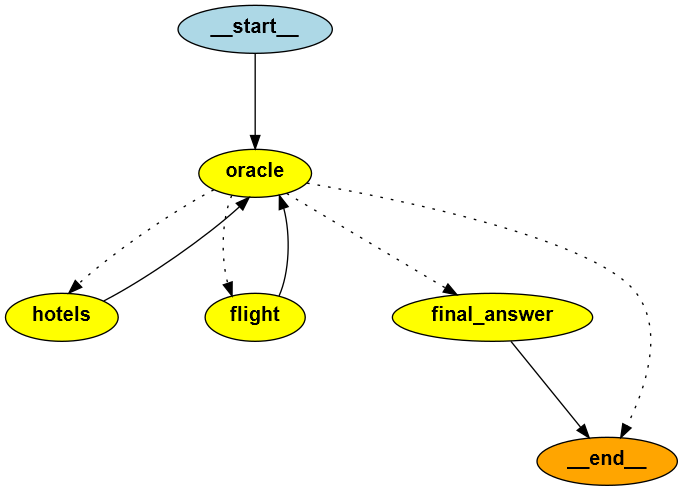

In [98]:
from IPython.display import Image

Image(runnable.get_graph().draw_png())

In [99]:
out = runnable.invoke({
    "input": "Can you give me information on what I can do in paris?",
    "chat_history": [],
})

run_oracle
intermediate_steps: []
final_answer.invoke(input={'summary': '- Visit the Eiffel Tower: Iconic landmark offering panoramic views of Paris\n- Louvre Museum: Home to thousands of works of art including the Mona Lisa\n- Seine River Cruise: Enjoy a scenic boat ride along the Seine River'})


In [100]:
out = runnable.invoke({
    "input": "I want to book a flight from london to paris on 2025-01-15 with two people and only nonstop",
    "chat_history": [],
})

run_oracle
intermediate_steps: []
flight.invoke(input={'departure': 'LHR', 'arrival': 'CDG', 'date': '2025-01-15', 'people': 2, 'nonstop': 'true'})
run_oracle
intermediate_steps: [AgentAction(tool='flight', tool_input={'departure': 'LHR', 'arrival': 'CDG', 'date': '2025-01-15', 'people': 2, 'nonstop': 'true'}, log='TBD'), AgentAction(tool='flight', tool_input={'departure': 'LHR', 'arrival': 'CDG', 'date': '2025-01-15', 'people': 2, 'nonstop': 'true'}, log="[{'numberOfBookableSeats': 9, 'itineraries': [{'duration': 'PT1H20M', 'segments': [{'departure': {'iataCode': 'LHR', 'terminal': '4', 'at': '2025-01-15T06:20:00'}, 'arrival': {'iataCode': 'CDG', 'terminal': '2E', 'at': '2025-01-15T08:40:00'}, 'carrierCode': 'AF', 'number': '1381', 'aircraft': {'code': '223'}, 'operating': {'carrierCode': 'AF'}, 'duration': 'PT1H20M', 'id': '1', 'numberOfStops': 0, 'blacklistedInEU': False}]}], 'price': {'currency': 'EUR', 'total': '266.28', 'base': '128.00', 'fees': [{'amount': '0.00', 'type': 'SUPPL

In [70]:
print(out['intermediate_steps'][-1].model_dump()['tool_input']['summary'])

Option 1:
- Flight AF1381
  - Departure: LHR (London Heathrow Airport) at 06:20
  - Arrival: CDG (Paris Charles de Gaulle Airport) at 08:40
  - Duration: 1 hour 20 minutes
  - Price: EUR 266.28
- Additional service: Checked bags for EUR 30.00

Option 2:
- Flight AF1781
  - Departure: LHR (London Heathrow Airport) at 14:45
  - Arrival: CDG (Paris Charles de Gaulle Airport) at 17:05
  - Duration: 1 hour 20 minutes
  - Price: EUR 266.28
- Additional service: Checked bags for EUR 30.00

Option 3:
- Flight AF1281
  - Departure: LHR (London Heathrow Airport) at 17:35
  - Arrival: CDG (Paris Charles de Gaulle Airport) at 19:55
  - Duration: 1 hour 20 minutes
  - Price: EUR 388.28
- Additional service: Checked bags for EUR 30.00


In [32]:
   
amadeus = Client(
    client_id=os.getenv("AMADEUS_CLIENT_ID"),
    client_secret=os.getenv("AMADEUS_CLIENT_SECRET"),
)

response = amadeus.reference_data.locations.hotels.by_city.get(
    cityCode='PAR',
    ratings=[5],
    radius=30)

hotels = response.data

# return hotels[:3]

In [ ]:
    response = amadeus.shopping.flight_offers_search.get(
        originLocationCode=departure,
        destinationLocationCode=arrival,
        departureDate=date,
        adults=people,
        nonStop = nonstop,
        max=5
    )

    flights = response.data

In [55]:
response = amadeus.shopping.flight_offers_search.get(
    originLocationCode='PAR',
    destinationLocationCode='LON',
    departureDate='2025-01-01',
    nonStop='true',
    adults=1,
)
flights = response.data

In [36]:
flights

[{'type': 'flight-offer',
  'id': '1',
  'source': 'GDS',
  'instantTicketingRequired': False,
  'nonHomogeneous': False,
  'oneWay': False,
  'isUpsellOffer': False,
  'lastTicketingDate': '2024-11-30',
  'lastTicketingDateTime': '2024-11-30',
  'numberOfBookableSeats': 4,
  'itineraries': [{'duration': 'PT1H5M',
    'segments': [{'departure': {'iataCode': 'ORY',
       'terminal': '1',
       'at': '2025-01-01T18:30:00'},
      'arrival': {'iataCode': 'LGW',
       'terminal': 'S',
       'at': '2025-01-01T18:35:00'},
      'carrierCode': 'VY',
      'number': '6948',
      'aircraft': {'code': '320'},
      'operating': {'carrierCode': 'VY'},
      'duration': 'PT1H5M',
      'id': '15',
      'numberOfStops': 0,
      'blacklistedInEU': False}]}],
  'price': {'currency': 'EUR',
   'total': '126.46',
   'base': '93.00',
   'fees': [{'amount': '0.00', 'type': 'SUPPLIER'},
    {'amount': '0.00', 'type': 'TICKETING'}],
   'grandTotal': '126.46'},
  'pricingOptions': {'fareType': ['PUBL

In [33]:
len(hotels)

107

In [68]:
hotels[0].keys()

dict_keys(['chainCode', 'iataCode', 'dupeId', 'name', 'hotelId', 'geoCode', 'address', 'distance', 'rating', 'lastUpdate'])

In [69]:
hotels[0]

{'chainCode': 'HN',
 'iataCode': 'PAR',
 'dupeId': 502345065,
 'name': 'TEST PROPERTY FOR API ACTIVATE/DE-ACTIVA',
 'hotelId': 'HNPARNUJ',
 'geoCode': {'latitude': 48.85315, 'longitude': 2.34513},
 'address': {'countryCode': 'FR'},
 'distance': {'value': 0.27, 'unit': 'KM'},
 'rating': 5,
 'lastUpdate': '2024-11-27T10:25:19'}

# Ollama with tool calling

In [ ]:
['numberOfBookableSeats','itineraries','price','fareDetailsBySegment']

In [88]:
from pydantic import BaseModel

class Rec(BaseModel):
    numberOfBookableSeats: int
    itineraries: list
    price: dict

    def __str__(self):
        """LLM-friendly string representation of the recommendation(s)."""
        return f"Bookabel Seats: {self.numberOfBookableSeats}\nItineraries: {self.itineraries}\nPrice: {self.price}"

In [89]:
# from langchain_core.tools import tool
# from amadeus import Client, ResponseError
# import os
# from dotenv import load_dotenv
# from tenacity import retry, stop_after_attempt, wait_exponential

# # Load variables from the .env file
# load_dotenv()
    
# amadeus = Client(
#     client_id=os.getenv("AMADEUS_CLIENT_ID"),
#     client_secret=os.getenv("AMADEUS_CLIENT_SECRET"),
# )

# response = amadeus.shopping.flight_offers_search.get(
#     originLocationCode='LON',
#     destinationLocationCode='PAR',
#     departureDate='2025-01-01',
#     adults=1,
# )

# flights = response.data

# keys_to_filter = ['numberOfBookableSeats','itineraries','price','fareDetailsBySegment']

# filtered_list = [
#     {key: value for key, value in dictionary.items() if key in keys_to_filter}
#     for dictionary in flights
# ]

# filtered_list[0]

In [90]:
@tool
def flight(departure: str, arrival: str, date: str) -> list[Rec]:
    """Find Three letter code for Departure and arrival / find date of trip"""
    
    amadeus = Client(
        client_id=os.getenv("AMADEUS_CLIENT_ID"),
        client_secret=os.getenv("AMADEUS_CLIENT_SECRET"),
    )

    response = amadeus.shopping.flight_offers_search.get(
        originLocationCode=departure,
        destinationLocationCode=arrival,
        departureDate=date,
        adults=1,
    )
    flights = response.data

    keys_to_filter = ['numberOfBookableSeats','itineraries','price']

    filtered_list = [
        {key: value for key, value in dictionary.items() if key in keys_to_filter}
        for dictionary in flights
    ]


    return filtered_list[:3]